#### OSQP Version of the combined MPC and trajectory planner

In [7]:
import casadi as ca
import numpy as np
from scipy import sparse
import control as ct
import osqp
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
## Linearisation

x = ca.SX.sym("x", 12)
u = ca.SX.sym("u", 4)

m = 1  # kg
g = 10  # m/s^2
Ix, Iy, Iz = 0.11, 0.11, 0.04  # kg m^2
l = 0.2  # m (this drops out when controlling via torques)
dt=0.1

parms = {"Q": np.eye(12), "R": np.eye(4), "N": 10, "Qf": np.eye(12), "dynamic": True}

# non linear dynamics
x_x, x_y, x_z, x_phi, x_theta, x_psi, x_dx, x_dy, x_dz, x_dphi, x_dtheta, x_dpsi = ca.vertsplit(x, 1)
u_F, u_Tx, u_Ty, u_Tz = ca.vertsplit(u, 1)

dx_x = x_dx
dx_y = x_dy
dx_z = x_dz
dx_phi = x_dphi
dx_theta = x_dtheta
dx_psi = x_dpsi
dx_dx = u_F/m * (ca.cos(x_phi)*ca.sin(x_theta)*ca.cos(x_psi) + ca.sin(x_phi)*ca.sin(x_psi))
dx_dy = u_F/m * (ca.cos(x_phi)*ca.sin(x_theta)*ca.sin(x_psi)+ca.sin(x_phi)*ca.cos(x_psi))
dx_dz = u_F/m * ca.cos(x_phi) * ca.cos(x_theta) - g
dx_dphi = 1/Ix * (u_Tx + x_dtheta * x_dpsi*(Iy - Iz))
dx_dtheta = 1/Iy * (u_Ty + x_dpsi*x_dphi*(Iz - Ix))
dx_dpsi = 1/Iz * (u_Tz + x_dphi*x_dtheta*(Ix-Iy))

x_dot = ca.vertcat(dx_x, dx_y, dx_z, dx_phi, dx_theta, dx_psi, dx_dx, dx_dy, dx_dz, dx_dphi, dx_dtheta, dx_dpsi)
f = x_dot
dynamics = ca.Function("quadrotor_dyn", [x, u], [x + dt * x_dot])

# this is continuous or discrete time?
#jac_dyn_x = ca.jacobian(self.x + self.dt * x_dot, self.x)
#jac_dyn_u = ca.jacobian(self.x + self.dt * x_dot, self.u)
#self.jac_dyn_x = ca.Function("jac_dyn_x", [self.x, self.u], [jac_dyn_x])
#self.jac_dyn_u = ca.Function("jac_dyn_u", [self.x, self.u], [jac_dyn_u])

x_operating = np.zeros((12, 1))
u_operating = np.array([9.8, 0, 0, 0]).reshape((-1, 1))  # hovering (mg 0 0 0)

A = ca.Function("A", [x, u], [ca.jacobian(f, x)])(x_operating, u_operating)
B = ca.Function("B", [x, u], [ca.jacobian(f, u)])(x_operating, u_operating)
C = np.eye(12)
D = np.zeros((12, 4))

#make numerical matrices and cast into numpy array
A = np.array(ca.DM(A))
B = np.array(ca.DM(B))

lin_ss_cont = ct.ss(A,B,C,D)
lin_ss_disc = ct.c2d(lin_ss_cont,dt,method='zoh')

print(lin_ss_disc)
print(type(lin_ss_disc.A), lin_ss_disc.A.shape)

<StateSpace>: sys[0]$sampled
Inputs (4): ['u[0]', 'u[1]', 'u[2]', 'u[3]']
Outputs (12): ['y[0]', 'y[1]', 'y[2]', 'y[3]', 'y[4]', 'y[5]', 'y[6]', 'y[7]', 'y[8]', 'y[9]', 'y[10]', 'y[11]']
States (12): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]', 'x[6]', 'x[7]', 'x[8]', 'x[9]', 'x[10]', 'x[11]']

A = [[1.         0.         0.         0.         0.049      0.
      0.1        0.         0.         0.         0.00163333 0.        ]
     [0.         1.         0.         0.049      0.         0.
      0.         0.1        0.         0.00163333 0.         0.        ]
     [0.         0.         1.         0.         0.         0.
      0.         0.         0.1        0.         0.         0.        ]
     [0.         0.         0.         1.         0.         0.
      0.         0.         0.         0.1        0.         0.        ]
     [0.         0.         0.         0.         1.         0.
      0.         0.         0.         0.         0.1        0.        ]
     [0.       

For OSQP, we need to express our problem in a specific format:

$$\text{Minimise }\frac{1}{2}x^{T}Px+q^{T}x$$
$$\text{subject to }l\leq Ax\leq u$$

Need to define, P, l, u, and A

In [3]:
## NOTE We are assuming N=10 here - should probably generalise it

# Define problem data
p = np.block([[np.eye(120,120), np.zeros((120,40))],[np.zeros((40,120)), np.eye(40,40)]])
print(p.shape)

l = np.zeros((240,1))
u = np.zeros((240,1))

A = np.zeros((240,160))

## Arrays are addressed by (row, column)

## Part 1. Input limits (rows 0:40)
for i in range(0,40,4) :
    l[i] = -10
    u[i] = 10
    l[i+1] = -1.475
    u[i+1] = 1.475
    l[i+2] = -1.475
    u[i+2] = 1.475
    l[i+3] = -0.0196
    u[i+3] = 0.0196
    
    A[i,120+i] = 1
    A[i+1,120+i+1] = 1
    A[i+2,120+i+2] = 1
    A[i+3,120+i+3] = 1

## Part 2. Roll/Pitch Angle limits (rows 40:60)
for i in range(0,10):
    l[40+2*i] = -np.pi/2
    u[40+2*i] = np.pi/2
    l[40+2*i+1] = -np.pi/2
    u[40+2*i+1] = np.pi/2

    A[40+2*i,12*i+3] = 1
    A[40+2*i+1,12*i+4] = 1

## Part 3. Velocity Constraints (rows 60:90)
for i in range(0,10):
    l[60+3*i] = -2
    u[60+3*i] = 2
    l[60+3*i+1] = -2
    u[60+3*i+1] = 2
    l[60+3*i+2] = -2
    u[60+3*i+2] = 2

    A[60+3*i,12*i+6] = 1
    A[60+3*i+1,12*i+7] = 1
    A[60+3*i+2,12*i+8] = 1

## Part 4. Angular Rate Constraints (rows 90:120)
for i in range(0,10):
    l[90+3*i] = -3*np.pi
    u[90+3*i] = 3*np.pi
    l[90+3*i+1] = -3*np.pi
    u[90+3*i+1] = 3*np.pi
    l[90+3*i+2] = -3*np.pi
    u[90+3*i+2] = 3*np.pi

    A[90+3*i,12*i+9] = 1
    A[90+3*i+1,12*i+10] = 1
    A[90+3*i+2,12*i+11] = 1

## Part 5. System Dynamics (as constraints) (rows 120:240)
for i in range(0,10):
    ## Add identity matrix
    A[120+12*i:120+12*(i+1),12*i:12*(i+1)] = np.eye(12)

    ## Add A matrix but skip in first iteration
    if i!=0:
        A[120+12*i:120+12*(i+1), 12*(i-1):12*i] = -1*lin_ss_disc.A

    ## Add B matrix
    A[120+12*i:120+12*(i+1), 120+4*i:120+4*(i+1)] = -1*lin_ss_disc.B

## NOTE This happens as part of iteration -- Part 6. Lower and upper with initial state (this is what gets updated each step)

## Convert to sparse matrix NOTE This should just be used originally
p = sparse.csc_matrix(p)
A = sparse.csc_matrix(A)

'''
q = np.array([1, 1])
A = sparse.csc_matrix([[1, 1], [1, 0], [0, 1]])
l = np.array([1, 0, 0])
u = np.array([1, 0.7, 0.7])

# Create an OSQP object
prob = osqp.OSQP()

# Setup workspace and change alpha parameter
prob.setup(P, q, A, l, u, alpha=1.0)

# Solve problem
res = prob.solve()
'''

(160, 160)


'\nq = np.array([1, 1])\nA = sparse.csc_matrix([[1, 1], [1, 0], [0, 1]])\nl = np.array([1, 0, 0])\nu = np.array([1, 0.7, 0.7])\n\n# Create an OSQP object\nprob = osqp.OSQP()\n\n# Setup workspace and change alpha parameter\nprob.setup(P, q, A, l, u, alpha=1.0)\n\n# Solve problem\nres = prob.solve()\n'

In [34]:
## Loop

u_loop = []
x_loop = []
statuses = []

# We use a 0.1s step time for 10 seconds (100 steps)
# Each step, we update the lower and upper matrix with the current state vector
# For reference tracking, we also need a q matrix to be updated with the state reference vector (for the states we are controlling)

prob = osqp.OSQP()
prob.setup(p, None, A, l, u, alpha=1.0, verbose=False)
#prob.codegen('./cgen', force_rewrite=True)

x_ref = np.array([4, 5, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0])
q = -2*np.tile(x_ref,10)@p
x0 = np.array([3, 10, 2, 0.75, 0, 0, 0, 0, 0, 0, 0, 0])
for i in range(0,100):
    ## Store state vector for plotting
    x_loop.append(x0)
    
    ## Update l and u matrices
    l[120:120+12] = np.matmul(lin_ss_disc.A, x0).reshape((12,1))
    u[120:120+12] = np.matmul(lin_ss_disc.A, x0).reshape((12,1))

    ## Update q NOTE q (reference trajectory) is constant for now

    ## Update and solve
    prob.update(l=l, u=u, q=q)
    res = prob.solve()
    statuses.append(res.info.status)

    ## Extract next control inputs
    u_next = res.x[120:124]
    u_loop.append(u_next)

    ## Recompute system dynamics
    x0 = np.matmul(lin_ss_disc.A, x0)+np.matmul(lin_ss_disc.B,u_next)

print(f'{sum([1 if e=='solved' else 0 for e in statuses])*100/len(statuses)}% solved')
print(np.tile(x_ref,10)@p)

100.0% solved
[4. 5. 7. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 5. 7. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 4. 5. 7. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 4. 5. 7. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 5. 7. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 4. 5. 7. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 4. 5. 7. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 5. 7. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 4. 5. 7. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 4. 5. 7. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


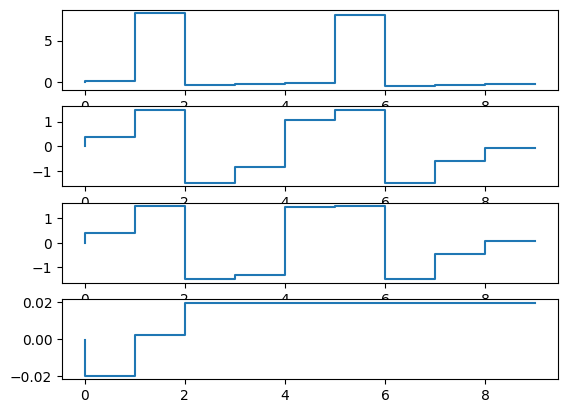

In [17]:
## Results plotting

res_f = [res.x[120+4*i] for i in range(0,10)]
res_roll = [res.x[120+4*i+1] for i in range(0,10)]
res_pitch = [res.x[120+4*i+2] for i in range(0,10)]
res_yaw = [res.x[120+4*i+3] for i in range(0,10)]

fig, axs = plt.subplots(4,1)
axs[0].step(range(0,10), res_f, '#1f77b4', label=r'Total Thrust')
axs[1].step(range(0,10), res_roll, '#1f77b4', label=r'Total Thrust')
axs[2].step(range(0,10), res_pitch, '#1f77b4', label=r'Total Thrust')
axs[3].step(range(0,10), res_yaw, '#1f77b4', label=r'Total Thrust')
plt.show()

In [29]:
'''
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting (even if not used directly)
#from mpl_toolkits.mplot3d import Axes3D
#from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Generate 3D parametric curve data
x = [x_loop[i][0] for i in range(0,100)]
y = [x_loop[i][1] for i in range(0,100)]
z = [x_loop[i][2] for i in range(0,100)]


# Create a 3D plot
fig = plt.figure(figsize=(12, 4), constrained_layout=True)

ax = fig.add_subplot(1,2,1, projection='3d')
ax.view_init(elev=20, azim=60)


xlim = (0, 10)
ylim = (0, 10)
zlim = (0, 10)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

# Define the face polygons
xy_plane = [[
    [xlim[0], ylim[0], zlim[0]],
    [xlim[1], ylim[0], zlim[0]],
    [xlim[1], ylim[1], zlim[0]],
    [xlim[0], ylim[1], zlim[0]]
]]
xz_plane = [[
    [xlim[0], ylim[0], zlim[0]],
    [xlim[1], ylim[0], zlim[0]],
    [xlim[1], ylim[0], zlim[1]],
    [xlim[0], ylim[0], zlim[1]]
]]
yz_plane = [[
    [xlim[0], ylim[0], zlim[0]],
    [xlim[0], ylim[1], zlim[0]],
    [xlim[0], ylim[1], zlim[1]],
    [xlim[0], ylim[0], zlim[1]]
]]

# Add colored planes
ax.add_collection3d(Poly3DCollection(xy_plane, color='red', alpha=0.1))
ax.add_collection3d(Poly3DCollection(xz_plane, color='green', alpha=0.1))
ax.add_collection3d(Poly3DCollection(yz_plane, color='blue', alpha=0.1))




# Plot the curve
ax.plot(x, y, z, label='Position', linestyle='--', color='purple')
ax.plot(0, y, z, label='Y-Z plane', color='blue')
ax.plot(x, 0, z, label='X-Z plane', color='green')
ax.plot(x, y, 0, label='X-Y plane', color='red')

# Optional: label axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Position')
ax.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.step(np.linspace(0,10,100), u_loop, label=['Total Thrust', 'Roll', 'Pitch', 'Yaw'])
ax2.legend()
    
plt.show()
'''

"\nimport numpy as np\nimport matplotlib.pyplot as plt\n#from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting (even if not used directly)\n#from mpl_toolkits.mplot3d import Axes3D\n#from mpl_toolkits.mplot3d.art3d import Poly3DCollection\n\n# Generate 3D parametric curve data\nx = [x_loop[i][0] for i in range(0,100)]\ny = [x_loop[i][1] for i in range(0,100)]\nz = [x_loop[i][2] for i in range(0,100)]\n\n\n# Create a 3D plot\nfig = plt.figure(figsize=(12, 4), constrained_layout=True)\n\nax = fig.add_subplot(1,2,1, projection='3d')\nax.view_init(elev=20, azim=60)\n\n\nxlim = (0, 10)\nylim = (0, 10)\nzlim = (0, 10)\nax.set_xlim(xlim)\nax.set_ylim(ylim)\nax.set_zlim(zlim)\n\n# Define the face polygons\nxy_plane = [[\n    [xlim[0], ylim[0], zlim[0]],\n    [xlim[1], ylim[0], zlim[0]],\n    [xlim[1], ylim[1], zlim[0]],\n    [xlim[0], ylim[1], zlim[0]]\n]]\nxz_plane = [[\n    [xlim[0], ylim[0], zlim[0]],\n    [xlim[1], ylim[0], zlim[0]],\n    [xlim[1], ylim[0], zlim[1]],\n    [xlim

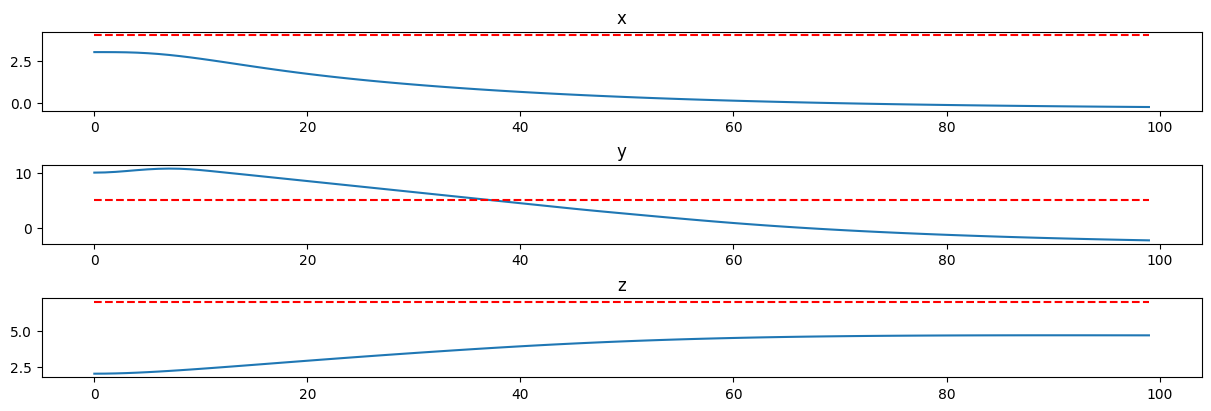

In [28]:
x = [x_loop[i][0] for i in range(0,100)]
y = [x_loop[i][1] for i in range(0,100)]
z = [x_loop[i][2] for i in range(0,100)]

fig = plt.figure(figsize=(12, 4), constrained_layout=True)
ax = fig.add_subplot(3,1,1)
ax.plot(range(0,len(x)),x, label='x')
ax.plot(range(0,len(x)), x_ref[0].repeat(100), linestyle='--', color='red')
ax.set_title('x')

ax = fig.add_subplot(3,1,2)
ax.plot(range(0,len(y)),y)
ax.plot(range(0,len(y)), x_ref[1].repeat(100), linestyle='--', color='red')
ax.set_title('y')

ax = fig.add_subplot(3,1,3)
ax.plot(range(0,len(z)),z)
ax.plot(range(0,len(z)), x_ref[2].repeat(100), linestyle='--', color='red')
ax.set_title('z')

plt.show()

In [16]:
### Mixer Algorithms
print(len(u_loop))

mixer = np.array([[1, -1, 1, 1],
                  [1, 1, -1, 1],
                  [1, 1, 1, -1],
                  [1, -1, -1, -1]])
print(u_loop[0])
print(mixer@u_loop[0])

100
[ 0.97605921 -1.47498833 -0.52399259  0.02192939]
[ 1.94898435  0.04699286 -1.0448511   2.95311074]
